## 1. Código Data Science Machine Learning

In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.linear_model import Ridge
from xgboost import XGBRFRegressor
from pycaret.regression import setup, compare_models, create_model, tune_model, plot_model, evaluate_model, finalize_model, predict_model, save_model, load_model
import warnings
warnings.filterwarnings("ignore")
import warnings
warnings.filterwarnings("ignore")

In [2]:
path = "D:/Downloads/INTELIGENCIA ARTIFICIAL/actividad individual/"

In [3]:
dataset = pd.read_csv(path + "dataset_APP.csv",header = 0,sep=";",decimal=",") 
prueba = pd.read_csv(path + "prueba_APP.csv",header = 0,sep=";",decimal=",")

In [4]:
dataset.head(2)

,Email,Address,dominio,Tec,Avg. Session Length,Time on App,Time on Website,Length of Membership,price
0,amandadean@gmail.com,Munich,gmail,Smartphone,32.063775,10.719150,37.712509,3.004743,503.0
1,kimberly46@garcia-nelson.biz,Ausburgo,Otro,Portatil,31.661050,11.398064,36.594457,3.198399,414.0


In [5]:
prueba.head(2)

,Email,Address,dominio,Tec,Avg. Session Length,Time on App,Time on Website,Length of Membership,price
0,lucastaylor@yahoo.com,Munich,yahoo,PC,33.946241,10.983977,37.951489,3.050713,642.0
1,theresamitchell@martin-chambers.biz,Munich,Otro,Smartphone,31.827979,12.461147,37.428997,2.974737,422.0


### Datos faltantes en dataset

In [6]:
ft = pd.DataFrame(dataset.isnull().sum()).reset_index()
ft.columns = ["Variable","Faltantes"]
ft["% Faltantes"] = ft["Faltantes"] * 100 / dataset.shape[0]
ft.loc[ft["% Faltantes"]>0]

,Variable,Faltantes,% Faltantes


In [7]:
formato = pd.DataFrame({'Variable': list(dataset.columns), 'Formato': dataset.dtypes })
ft = pd.merge(ft,formato,on=["Variable"],how="left")
ft.head()

,Variable,Faltantes,% Faltantes,Formato
0,Email,0,0.0,object
1,Address,0,0.0,object
2,dominio,0,0.0,object
3,Tec,0,0.0,object
4,Avg. Session Length,0,0.0,float64


### Datos faltantes en prueba

In [8]:
ft2 = pd.DataFrame(prueba.isnull().sum()).reset_index()
ft2.columns = ["Variable","Faltantes"]
ft2["% Faltantes"] = ft2["Faltantes"] * 100 / prueba.shape[0]
ft2.loc[ft2["% Faltantes"]>0]

,Variable,Faltantes,% Faltantes


In [9]:
formato2 = pd.DataFrame({'Variable': list(prueba.columns), 'Formato': prueba.dtypes })
ft = pd.merge(ft2,formato2,on=["Variable"],how="left")
ft

,Variable,Faltantes,% Faltantes,Formato
0,Email,0,0.0,object
1,Address,0,0.0,object
2,dominio,0,0.0,object
3,Tec,0,0.0,object
4,Avg. Session Length,0,0.0,float64
5,Time on App,0,0.0,float64
6,Time on Website,0,0.0,float64
7,Length of Membership,0,0.0,float64
8,price,0,0.0,float64


## Análisis descriptivo

In [10]:
cuantitativas = list(formato.loc[formato["Formato"]!="object","Variable"])
cuantitativas = [x for x in cuantitativas if x not in ["Email","Address"]]

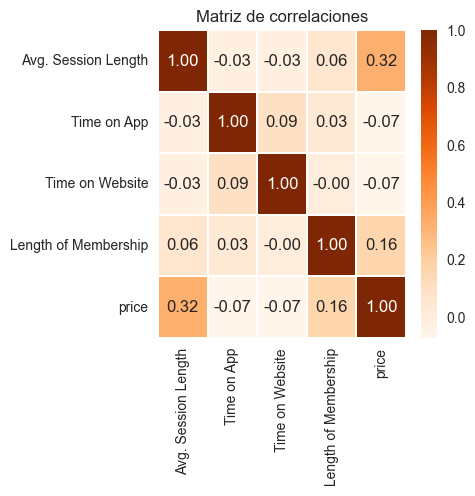

In [11]:
co = dataset.get(cuantitativas).copy()
cor_ = co.corr()
plt.figure(figsize=(4,4))
sns.heatmap(cor_, linewidths=0.01, annot=True, fmt = ".2f", cmap="Oranges")
plt.title("Matriz de correlaciones")
plt.show()

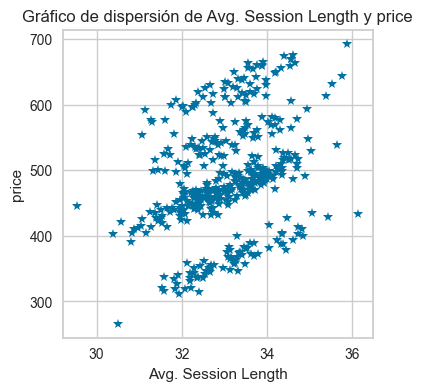

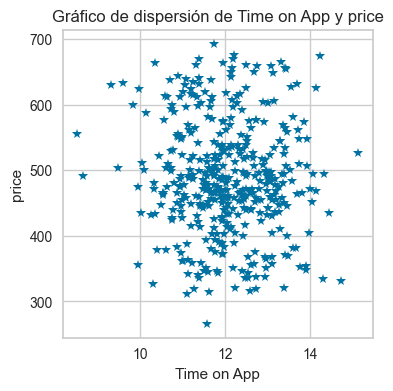

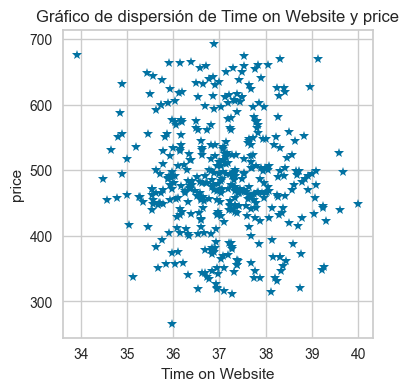

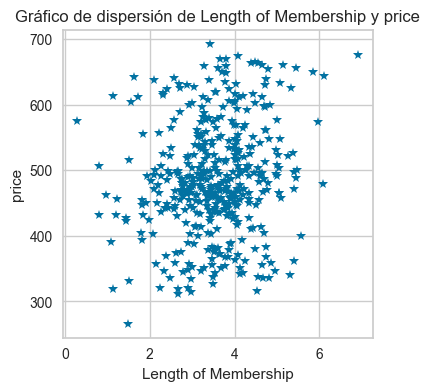

In [12]:
cuantitativas = [x for x in cuantitativas if x not in ["Email","Address","price"]]
for k in cuantitativas:
    plt.figure(figsize=(4,4))
    plt.plot(dataset[k],dataset["price"],'*b')
    plt.xlabel(k); plt.ylabel("price")
    plt.title("Gráfico de dispersión de "+k+" y price")

In [13]:
ft

,Variable,Faltantes,% Faltantes,Formato
0,Email,0,0.0,object
1,Address,0,0.0,object
2,dominio,0,0.0,object
3,Tec,0,0.0,object
4,Avg. Session Length,0,0.0,float64
5,Time on App,0,0.0,float64
6,Time on Website,0,0.0,float64
7,Length of Membership,0,0.0,float64
8,price,0,0.0,float64


In [14]:
categoricas = list(formato.loc[formato["Formato"]=="O","Variable"])
categoricas = [x for x in categoricas if x not in ["Email","Address"]]

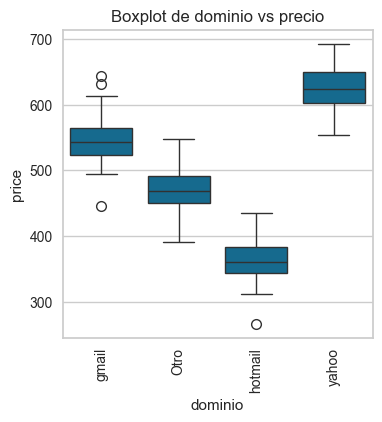

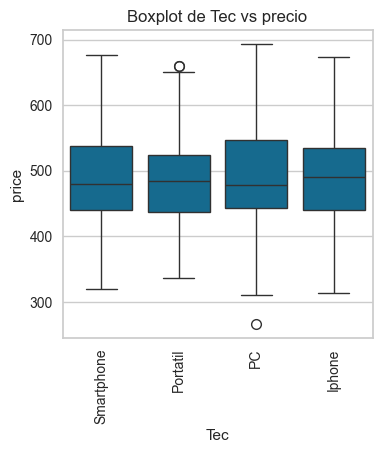

In [15]:
for k in categoricas:
    plt.figure(figsize=(4,4))
    sns.boxplot(x = k, y = "price",data=dataset)
    plt.title("Boxplot de "+k+" vs precio")
    plt.xticks(rotation = 90)
    plt.show()

In [16]:
cuantitativas

['Avg. Session Length',
 'Time on App',
 'Time on Website',
 'Length of Membership']

In [17]:
categoricas

['dominio', 'Tec']

## base sin ingeniería

In [18]:
base_modelo = pd.concat([dataset.get(cuantitativas),dataset.get(categoricas)],axis = 1)
base_modelo["y"] = dataset["price"].copy()
base_modelo.head()

,Avg. Session Length,Time on App,Time on Website,Length of Membership,dominio,Tec,y
0,32.063775,10.719150,37.712509,3.004743,gmail,Smartphone,503.0
1,31.661050,11.398064,36.594457,3.198399,Otro,Portatil,414.0
2,32.838100,12.364342,38.039109,3.309182,Otro,PC,467.0
3,34.357196,9.477778,37.906015,5.047023,Otro,Iphone,503.0
4,34.814984,12.114945,36.288724,4.389455,hotmail,Smartphone,411.0


In [19]:
# Configuración del experimento
exp_clf101 = setup(data=base_modelo,
target='y',
session_id=123,
train_size=0.7,
numeric_features = cuantitativas,
categorical_features = categoricas)

,Description,Value
0,Session id,123
1,Target,y
2,Target type,Regression
3,Original data shape,"(425, 7)"
4,Transformed data shape,"(425, 13)"
5,Transformed train set shape,"(297, 13)"
6,Transformed test set shape,"(128, 13)"
7,Numeric features,4
8,Categorical features,2
9,Preprocess,True


In [20]:
%%time
# Comparación de modelos
best_model = compare_models() ## accuracy

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lr,Linear Regression,8.5022,111.8182,10.5077,0.9830,0.0219,0.0177,0.6970
lar,Least Angle Regression,8.5022,111.8182,10.5077,0.9830,0.0219,0.0177,0.0520
br,Bayesian Ridge,8.5061,111.8091,10.5076,0.9830,0.0219,0.0177,0.0550
ridge,Ridge Regression,8.7794,114.7575,10.6524,0.9826,0.0223,0.0183,0.0650
lasso,Lasso Regression,9.6062,135.5250,11.5572,0.9799,0.0241,0.0201,0.0570
llar,Lasso Least Angle Regression,9.6064,135.5295,11.5573,0.9799,0.0241,0.0201,0.0720
gbr,Gradient Boosting Regressor,10.6267,182.5007,13.3682,0.9721,0.0284,0.0224,0.0980
huber,Huber Regressor,11.1761,203.3476,14.1767,0.9693,0.0296,0.0235,0.0580
et,Extra Trees Regressor,11.4145,214.6837,14.4923,0.9679,0.0310,0.0240,0.1440
xgboost,Extreme Gradient Boosting,11.3830,220.0183,14.7013,0.9673,0.0311,0.0239,0.1060


CPU times: total: 3.42 s
Wall time: 24.5 s


## Ejercicio

Construya una API en streamlit con un modelo Ridge por medio de un optimizador Bayesiano siguiendo la misma metodología de la retroalimentación de ayer

Hora de entrega: 9:40 pm

In [21]:
dt = create_model('ridge')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,8.9530,128.7901,11.3486,0.9866,0.0226,0.0183
1,7.9197,92.0253,9.5930,0.9869,0.0201,0.0167
2,8.0164,93.2436,9.6563,0.9863,0.0192,0.0166
3,8.7590,107.0550,10.3467,0.9871,0.0229,0.0192
4,8.3257,97.0050,9.8491,0.9790,0.0213,0.0176
5,7.6757,89.7099,9.4715,0.9826,0.0199,0.0161
6,10.1416,171.7096,13.1038,0.9851,0.0275,0.0209
7,8.6775,103.9082,10.1935,0.9856,0.0211,0.0174
8,9.9808,143.7494,11.9896,0.9704,0.0268,0.0218


In [22]:
from pycaret.regression import *
hyperparameters = dt.get_params()
hyperparameters

{'alpha': 1.0,
 'copy_X': True,
 'fit_intercept': True,
 'max_iter': None,
 'positive': False,
 'random_state': 123,
 'solver': 'auto',
 'tol': 0.0001}

In [23]:
param_grid_bayesian = {
    'alpha': np.arange(1,1001,1)
}
# Perform Bayesian Search
tuned_dt = tune_model(dt, custom_grid=param_grid_bayesian, search_library='scikit-optimize', search_algorithm='bayesian',fold=5)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,28.6865,1404.9241,37.4823,0.8318,0.0808,0.0623
1,28.9372,1336.9564,36.5644,0.8237,0.0861,0.0674
2,21.5702,842.8944,29.0326,0.8303,0.0591,0.0442
3,33.6495,1736.4464,41.6707,0.8167,0.0845,0.0687
4,20.3594,850.4762,29.1629,0.8282,0.0672,0.0460
Mean,26.6406,1234.3395,34.7826,0.8261,0.0755,0.0577
Std,4.9749,344.1863,4.9508,0.0054,0.0106,0.0106


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


In [24]:
evaluate_model(tuned_dt)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [25]:
predictions_test = predict_model(tuned_dt)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Ridge Regression,7.1022,84.9182,9.2151,0.9882,0.0201,0.0151


In [26]:
predictions_train = predict_model(tuned_dt, data=exp_clf101.get_config('X_train'))

In [27]:
y_train = get_config('y_train')
y_test = get_config('y_test')

In [28]:
from sklearn.metrics import mean_squared_error
# Error de entrenamiento
print(mean_squared_error(y_train,predictions_train["prediction_label"]))
# Error de test
print(mean_squared_error(y_test,predictions_test["prediction_label"]))

106.2620455135176
84.91818066459535


In [29]:
final_dt = finalize_model(tuned_dt)

In [30]:
path2 = "D:/Downloads/INTELIGENCIA ARTIFICIAL/actividad individual/"

In [31]:
import pickle
with open(path2 + 'best_model.pkl', 'wb') as model_file:
    pickle.dump(final_dt, model_file)

## DISEÑO API

In [32]:
base_modelo.head(1)


,Avg. Session Length,Time on App,Time on Website,Length of Membership,dominio,Tec,y
0,32.063775,10.71915,37.712509,3.004743,gmail,Smartphone,503.0


In [33]:
base_modelo = base_modelo.drop('y', axis=1)
base_modelo.head(1)

,Avg. Session Length,Time on App,Time on Website,Length of Membership,dominio,Tec
0,32.063775,10.71915,37.712509,3.004743,gmail,Smartphone


In [34]:
Avg = 32.063775	
time_app = 10.71915	
time_web = 37.712509
lenght_mem = 3.004743
dominio = "gmail" ## select box ['Otro', 'hotmail', 'yahoo']
tec = "Smartphone" ## select box ['Portatil', 'PC', 'Iphone']

In [35]:
user = pd.DataFrame({'x1':[Avg],'x2': [time_app],'x3': [time_web], 'x4': [lenght_mem], 'x5': [dominio], 'x6':[tec]})
user.columns = base_modelo.columns

In [37]:
prueba2 = pd.concat([user,base_modelo],axis = 0)
prueba2.index = range(prueba2.shape[0])
prueba2.head(2)




,Avg. Session Length,Time on App,Time on Website,Length of Membership,dominio,Tec
0,32.063775,10.71915,37.712509,3.004743,gmail,Smartphone
1,32.063775,10.71915,37.712509,3.004743,gmail,Smartphone


In [38]:
cuantitativas

['Avg. Session Length',
 'Time on App',
 'Time on Website',
 'Length of Membership']

In [39]:
categoricas

['dominio', 'Tec']

In [40]:
# Carga el modelo desde el archivo
with open(path2 + 'best_model.pkl', 'rb') as model_file:
    dt2 = pickle.load(model_file)

In [41]:
df_test = base_modelo.copy()
predictions = predict_model(dt2, data=df_test)
predictions.head()

,Avg. Session Length,Time on App,Time on Website,Length of Membership,dominio,Tec,prediction_label
0,32.063774,10.719150,37.712509,3.004743,gmail,Smartphone,511.440227
1,31.661049,11.398065,36.594456,3.198399,Otro,Portatil,430.324007
2,32.838100,12.364342,38.039108,3.309182,Otro,PC,465.180844
3,34.357197,9.477777,37.906013,5.047022,Otro,Iphone,515.022499
4,34.814983,12.114945,36.288723,4.389455,hotmail,Smartphone,416.172285


In [42]:
predictions["y"] = predictions["prediction_label"].map(float)
predictions.head()

,Avg. Session Length,Time on App,Time on Website,Length of Membership,dominio,Tec,prediction_label,y
0,32.063774,10.719150,37.712509,3.004743,gmail,Smartphone,511.440227,511.440227
1,31.661049,11.398065,36.594456,3.198399,Otro,Portatil,430.324007,430.324007
2,32.838100,12.364342,38.039108,3.309182,Otro,PC,465.180844,465.180844
3,34.357197,9.477777,37.906013,5.047022,Otro,Iphone,515.022499,515.022499
4,34.814983,12.114945,36.288723,4.389455,hotmail,Smartphone,416.172285,416.172285


In [48]:
print('La predicción es :',predictions.iloc[0]["y"])

La predicción es : 511.4402269940931
